# A DSL alongside a Genetic Algorithm applied to the ARC Dataset

In this notebook, we present a minimalistic *Domain Specific Language* for some of the ARC tasks.

We instroduce the language and how it can be used to precess the input in complex ways. We then implement an evaluation function able to run a such program against an input image. We also provide a program solution of a task as an exemple.

In a second time, we implement a simple genetic algorithm (based on a multiobjective and elitist strategy) that is able to generate programs written in this DSL and demonstrate its usage against the same ARC task previously solved by hand.

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))
num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

In [2]:
# This code is used to display a task
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
def plot_one(ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)
    
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(axs[0],0,'test','input')
        plot_one(axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 
    
# Display each output of the function
def show_image_list(images):
    """ Show each image contained in a list. """
    p = plt.figure().subplots(1, len(images))
    if len(images) > 1:
        for i, image in enumerate(images):
            p[i].imshow(image, cmap=cmap, norm=norm)
    elif len(images) == 1:
        p.imshow(images[0], cmap=cmap, norm=norm)

In [3]:
def create_df(folder_path):
    task_names_list = sorted(os.listdir(folder_path))
    task_list = []
    for task_name in task_names_list: 
        task_file = str(folder_path / task_name)
        with open(task_file, 'r') as f:
            task = json.load(f)
            task_list.append(task)
    
    df = pd.DataFrame()
    df['task_name'] = task_names_list
    df['task'] = task_list
    df['number_of_train_pairs'] = df['task'].apply(lambda x: len(x['train']))
    df['number_of_test_pairs'] = df['task'].apply(lambda x: len(x['test']))
    
    # Compare image sizes
    df['inputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['input']) for example in task['train']])) == 1)
    )
    df['inputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['input'][0]) for example in task['train']])) == 1)
    )
    df['inputs_all_have_same_shape'] = df['inputs_all_have_same_height'] * df['inputs_all_have_same_width']
    df['input_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'])
                     if (len(set([len(example['input']) for example in task['train']])) == 1)
                     else np.nan
    )
    df['input_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) for example in task['train']])) == 1)
                     else np.nan
    )
    df['outputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['output']) for example in task['train']])) == 1)
    )
    df['outputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['output'][0]) for example in task['train']])) == 1)
    )
    df['outputs_all_have_same_shape'] = df['outputs_all_have_same_height'] * df['outputs_all_have_same_width']
    df['output_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'])
                     if (len(set([len(example['output']) for example in task['train']])) == 1)
                     else np.nan
    )
    df['output_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0])
                     if (len(set([len(example['output'][0]) for example in task['train']])) == 1)
                     else np.nan
    )  
    df['in_each_pair_shape_doesnt_change'] = df['task'].apply(
        lambda task: np.prod([int(len(example['input'][0])==len(example['output'][0])
                                  and len(example['input'])==len(example['output'])
                                 ) for example in task['train']
                            ])
    )
    df['in_each_pair_shape_ratio_is_the_same'] = df['task'].apply(
        lambda task: (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']]))==1) * (
                      len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']]))==1)
    )
    df['o/i_height_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output']) / len(task['train'][0]['input'])
                     if (len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']]))==1)
                     else np.nan
    )
    df['o/i_width_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0]) / len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']]))==1)
                     else np.nan
    )
    
    # my idea ---------
    df["same_color_sum"] = df['task'].apply(lambda task: 
                        np.all([int(sum(sum(np.array(example['input'])))== sum(sum(np.array(example['output'])))) for example in task['train']]))
    
    df["same_color_sum_in_edge"] = df['task'].apply(lambda task: 
                        np.all([int(sum(np.array(example['input'])[0,:]) +sum(np.array(example['input'])[:,0]) + 
                                    sum(np.array(example['input'])[-1,:]) +sum(np.array(example['input'])[:,-1])
                                    == 
                                    sum(np.array(example['output'])[0,:]) +sum(np.array(example['output'])[:,0]) + 
                                    sum(np.array(example['output'])[-1,:]) +sum(np.array(example['output'])[:,-1])) for example in task['train']]))
    
    #df["color_sum_ratio"] = df['task'].apply(lambda task: sum(sum(np.array(task['train'][0]['input'])))/sum(sum(np.array(task['train'][0]['output'])))
    #                    )

    #df["color_kind_diff"] = df["task"].apply(lambda task: len(np.unique(np.array(task['train'][0]['input'])))
    #                                         -len(np.unique(np.array(task['train'][0]['output']))))
    

    return df

training_descriptive_df = create_df(training_path)
evaluation_descriptive_df = create_df(evaluation_path)
test_descriptive_df = create_df(test_path)

# Domain Specific Language (DSL)

We will build a domain specific language specialized on processing list of images. To allow easy chaining of keyword from this language together, each *function* provided by this language will be take one or more images and transform it to none, one or more. The final result of our program will then be a list of images.

The DSL is so constituted by a collection of functions of type `np.array -> [np.array]` and `[np.array] -> [np.array]`.

The first kind of function take an image, and produce a list of images (for example, the image split by different colors). The second type of function take a list of images and produce a new list (for exemple, intersect).
[](http://)

## DSL Implementation

We start with the functions that take *one image* and produce an *a list of images*.](http://)

In [4]:
# np.array -> [np.array]
def groupByColor_unlifted(pixmap):
    """ Split an image into a collection of images with unique color """
    # Count the number of colors
    nb_colors = int(pixmap.max()) + 1
    # Create a pixmap for each color
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    # Filter out empty images
    return [x for x in splited if np.any(x)]

# np.array -> [np.array]
def cropToContent_unlifted(pixmap):
    """ Crop an image to fit exactly the non 0 pixels """
    # Op argwhere will give us the coordinates of every non-zero point
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0:
        return []
    # Take the smallest points and use them as the top left of our crop
    top_left = true_points.min(axis=0)
    # Take the largest points and use them as the bottom right of our crop
    bottom_right = true_points.max(axis=0)
    # Crop inside the defined rectangle
    pixmap = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    return [pixmap]

# np.array -> [np.array]
def splitH_unlifted(pixmap):
    """ Split horizontally an image """
    h = pixmap.shape[0]
    if h % 2 == 1:
        h = h // 2
        return [pixmap[:h,:], pixmap[h+1:,:]]
    else:
        h = h // 2
        return [pixmap[:h,:], pixmap[h:,:]]

# np.array -> [np.array]
def negative_unlifted(pixmap):
    """ Compute the negative of an image (and conserve the color) """
    negative = np.logical_not(pixmap).astype(int)
    color = max(pixmap.max(), 1)
    return [negative * color]

# np.array -> [np.array]
def rotation_unlifted(pixmap):
    """ Compute an image with rotation"""
    #90度反時計回り
    ans1 = np.rot90(np.array(pixmap))
    #180度反時計回り
    ans2 = np.rot90(np.array(pixmap), 2) 
    #270度反時計回り
    ans3 = np.rot90(np.array(pixmap), 3)
    return [ans1, ans2, ans3]
    
def unrotation_unlifted(pixmap):
    #90度時計回り
    ans4 = np.rot90(np.array(pixmap),-1)
    #180度時計回り
    ans5 = np.rot90(np.array(pixmap), -2)
    #270度時計回り
    ans6 = np.rot90(np.array(pixmap), -3) 
    return [ans4, ans5, ans6]

# np.array -> [np.array]
def flip_unlifted(pixmap):
    """ Compute an image with flip"""
    #左右反転
    ans1 = np.fliplr(np.array(pixmap))
    #上下反転
    ans2 = np.flipud(np.array(pixmap))
    #転置
    ans3 = np.transpose(np.array(pixmap))
    return [ans1, ans2, ans3]    

# np.array -> [np.array]
def splitV_unlifted(pixmap):
    """ Split horizontally an image """
    v = pixmap.shape[1]
    if v % 2 == 1:
        v = v // 2
        return [pixmap[:,:v], pixmap[:,v+1:]]
    else:
        v = v // 2
        return [pixmap[:,:v], pixmap[:,v:]]
    
def change_from0_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 0:
            continue
        res = pixmap.copy()
        res[pixmap==0] = i
        ans.append(res)
    return ans

def change_from1_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 1:
            continue
        res = pixmap.copy()
        res[pixmap==1] = i
        ans.append(res)
    return ans

def change_from2_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 2:
            continue
        res = pixmap.copy()
        res[pixmap==2] = i
        ans.append(res)
    return ans

def change_from3_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 3:
            continue
        res = pixmap.copy()
        res[pixmap==3] = i
        ans.append(res)
    return ans

def change_from4_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 4:
            continue
        res = pixmap.copy()
        res[pixmap==4] = i
        ans.append(res)
    return ans

def change_from5_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 5:
            continue
        res = pixmap.copy()
        res[pixmap==5] = i
        ans.append(res)
    return ans

def change_from6_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 6:
            continue
        res = pixmap.copy()
        res[pixmap==6] = i
        ans.append(res)
    return ans

def change_from7_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 7:
            continue
        res = pixmap.copy()
        res[pixmap==7] = i
        ans.append(res)
    return ans

def change_from8_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 8:
            continue
        res = pixmap.copy()
        res[pixmap==8] = i
        ans.append(res)
    return ans

def change_from9_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 9:
            continue
        res = pixmap.copy()
        res[pixmap==9] = i
        ans.append(res)
    return ans

def change_from10_unlifted(pixmap):
    ans = []
    for i in range(10):
        if i == 10:
            continue
        res = pixmap.copy()
        res[pixmap==10] = i
        ans.append(res)
    return ans

def copy_horizontal_unlifted(pixmap):
    return [pixmap.repeat(2, axis=0)]

def copy_vertical_unlifted(pixmap):
    return [pixmap.repeat(2, axis=1)]



We now write functions that take a list of images and transform it to a new list.

In [5]:
# [np.array] -> [np.array]
def identity(x: [np.array]):
    return x

# [np.array] -> [np.array]
def tail(x):
    if len(x) > 1:
        return x[1:]
    else:
        return x

# [np.array] -> [np.array]
def init(x):
    if len(x) > 1:
        return x[:1]
    else:
        return x

# [np.array] -> [np.array]
def union(x):
    """ Compute the pixel union of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [np.bitwise_or.reduce(np.array(x).astype(int))]
    
def intersect(x):
    """ Compute the pixel intersection of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [(np.prod(np.array(x), axis=0) > 0).astype(int)]

def sortByColor(xs):
    """ Sort pictures by increasing color id. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: x.max()))

def sortByWeight(xs):
    """ Sort images by how many non zero pixels are contained. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: (x>0).sum()))

def reverse(x):
    """ Reverse the order of a list of images. """
    return x[::-1]

## Composition of functions

It is important to make sure we can chain both functions. To compose two functions `f` and `g` of type `[np.array] -> [np.array]` ; We symply call `g(f([input_image]))`.


But for each function of the type `np.array -> [np.array]` some work is required. We need to generated a *lifted version* version of them. A function `f: np.array -> [np.array]` can be turned into a function of type `[np.array] -> [np.array]` by applying `f` on each image of the input list and concatenating the results.

---
If you want to know more about the `lift` concept, have a look to the concept of [*monades*](https://en.wikipedia.org/wiki/Monad_%28functional_programming%29). We are indeed using the *list monade*.

In [6]:
def lift(fct):
    # Lift the function
    def lifted_function(xs):
        list_of_results = [fct(x) for x in xs]
        return list(itertools.chain(*list_of_results))
    # Give a nice name to the lifted function
    import re
    lifted_function.__name__ = re.sub('_unlifted$', '_lifted', fct.__name__)
    return lifted_function

cropToContent = lift(cropToContent_unlifted)
groupByColor = lift(groupByColor_unlifted)
splitH = lift(splitH_unlifted)
negative = lift(negative_unlifted)
rotation = lift(rotation_unlifted)
unrotation = lift(unrotation_unlifted)
flip = lift(flip_unlifted)
splitV = lift(splitV_unlifted)
change_from0 = lift(change_from0_unlifted)
change_from1 = lift(change_from1_unlifted)
change_from2 = lift(change_from2_unlifted)
change_from3 = lift(change_from3_unlifted)
change_from4 = lift(change_from4_unlifted)
change_from5 = lift(change_from5_unlifted)
change_from6 = lift(change_from6_unlifted)
change_from7 = lift(change_from7_unlifted)
change_from8 = lift(change_from8_unlifted)
change_from9 = lift(change_from9_unlifted)
copy_horizontal = lift(copy_horizontal_unlifted)
copy_vertical = lift(copy_vertical_unlifted)

# Sample task

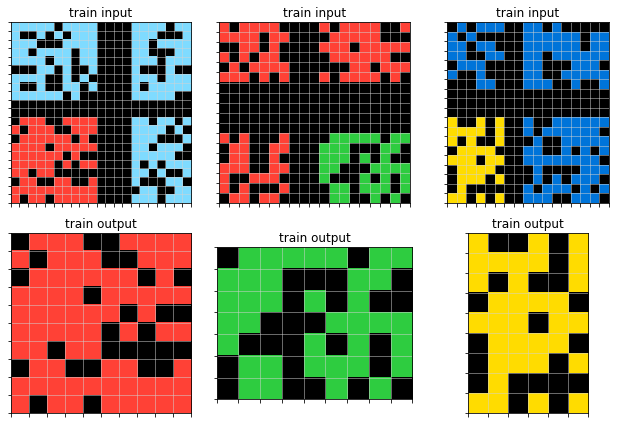

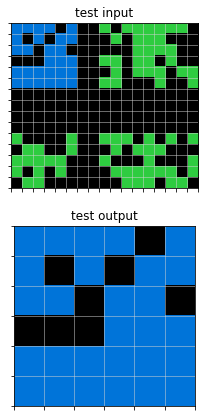

In [7]:
# Load my favorite task
task_file = str(training_path / training_tasks[13])
with open(task_file, 'r') as f:
    task = json.load(f)
    plot_task(task)

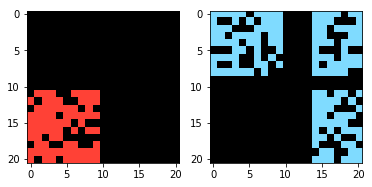

In [8]:
# Execute the group by color on the first input
input_image = np.array(task['train'][0]['input'])
images = groupByColor([input_image])

# Show the result of our function
show_image_list(images)

# Program evaluation


We define our building blocks for programs (the functions in our DSL). We will define a program as a list of functions from our DSL ; `program: [[np.array] -> [np.array]]`. The instructions in our programs will be executed *from left to right*. This mean that if we want to first `splitByColor` and then compute the `negative` of the image, we need to write `[splitByColor, negative]` in this order.

Let's first write an utilitary function to describe a program as a human readable string.

In [9]:
def program_desc(program):
    """ Create a human readable description of a program. """
    desc = [x.__name__ for x in program]
    return(' >> '.join(desc))

# Display the program description alongside its output
program = [splitH, groupByColor, negative, intersect]
print(program_desc(program))

splitH_lifted >> groupByColor_lifted >> negative_lifted >> intersect


## The evaluation method
We want to run and evaluate a such program on a pictures and then recover the result. This logic is realised by the `evaluate` function.

In [10]:
def evaluate(program: [], input_image: np.array):
    # Make sure the input is a np.array
    input_image = np.array(input_image)
    assert type(input_image) == np.ndarray
    
    # Apply each function on the image
    image_list = [input_image]
    for fct in program:
        # Apply the function
        image_list = fct(image_list)
        # Filter out empty images
        image_list = [img for img in image_list if img.shape[0] > 0 and img.shape[1] > 0]
        # Break if there is no data
        if image_list == []:
            return []
    return image_list        

## Simple test on a task
We apply the simple program `[groupByColor, negative]` on the task we loaded earlier.

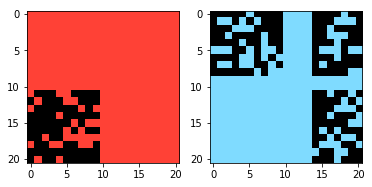

In [11]:
results = evaluate(program=[groupByColor, negative], input_image=task['train'][0]['input'])
show_image_list(results)

# Program generation (Genetic Algorithm)

We now have a simple and powerful language to express various transformation on images. But someone or something still have to write the actual program that can solve a task. In this part, we will implement a naive but somewhat efficient genetic algorithm that will be able to find by itself the solution to a task.

The strategy will be as follow:

* We generate random program with one node, and then run them. We keep the best solution (the *elites* of our population).
* Starting from this best solutions, we create new program though mutation. We avaluate them again and update our collection of elite.
* We continue doing this process again and again... until a solution is found.

---

Since we use multiple fitness function, our aproache can be qualified of [multi-objectives](https://en.wikipedia.org/wiki/Multi-objective_optimization) : we try to optimise multiple objectives at the same time.

Our *elites* can be understood as an approximation of the pareto surface (collection of pareto optimal solution). In our specific case, when a solution to the task exists in our DSL, their exists a global minimum that will be smaller than any candidate. In a such case the pareto surface is reduced to a single point. Nethertheless, this is a good image to keep in mind to understand what the collection of *elites* represent.

## Is a program solution ?

First, we need a way to know if a program is a solution of the given examples of a task.

In [12]:
def are_two_images_equals(a, b):
    if tuple(a.shape) == tuple(b.shape):
        if (np.abs(b-a) < 1).all():
            return True
    return False

def is_solution(program, task, verbose=True):
    for sample in task: # For each pair input/output
        i = np.array(sample['input'])
        o = np.array(sample['output'])

        # Evaluate the program on the input
        images = evaluate(program, i)
        if len(images) < 1:
            return False
        
        # The solution should be in the 3 first outputs
        images = images[:3]
        
        # Check if the output is in the 3 images produced
        is_program_of_for_sample = any([are_two_images_equals(x, o) for x in images])
        if not is_program_of_for_sample:
            return False
    
    return True

program = [groupByColor, cropToContent]
print(program_desc(program),"is a solution of the task:", is_solution(program, task['train']))

groupByColor_lifted >> cropToContent_lifted is a solution of the task: True


## Fitness

To help our algorithm progress in the right direction, we need a way to give a score to an existing program. The smaller is the score of the program, the closer we are to the solution. One can think of this score as a distance of our program to the optimal solution.

Notice that one can think of this program as a minimization problem (minimize `score`) or maximization problem (minimize `-score`). On machine learning it is common to minimise a distance wereas in genetic algorithm literature you can read that we maximize the fitness of an agent^1. Both convention work perfectly, but it is more convenient if we choose one and stick to it. Therefore, we will MINIMIZE the score of our programs.

Because we can't really comme up with one single good score function that would describe well the progression of the algorithm on all task of the dataset, we will evaluate how our program perform on different aspects through a collection of them.

---

^1: The reason you see maximization and positive score in Genetic Programming literature is that you need all your values to be positive in order to build a probability distribution over your population. Since we use an elitist algorithm instead of a sampling of the population for reproduction, we do not need this restriction.

In [13]:
def width_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right width. Less is better."""
    return np.abs(predicted.shape[0] - expected_output.shape[0])

def height_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right height. Less is better."""
    return np.abs(predicted.shape[1] - expected_output.shape[1])

def activated_pixels_fitness(p, e):
    """ How close the predicted image to have the right pixels. Less is better."""
    shape = (max(p.shape[0], e.shape[0]), max(p.shape[1], e.shape[1]))
    diff = np.zeros(shape, dtype=int)
    diff[0:p.shape[0], 0:p.shape[1]] = (p > 0).astype(int)
    diff[0:e.shape[0], 0:e.shape[1]] -= (e > 0).astype(int)
    
    return (diff != 0).sum()

def colors_fitness(p, e):
    p_colors = np.unique(p)
    e_colors = np.unique(e)
    
    nb_inter = len(np.intersect1d(p_colors, e_colors))

    return (len(p_colors) - nb_inter) + (len(e_colors) - nb_inter)

def colors_num_sum_fitness(p, e):
    p_colors_sum = np.sum(np.sum(p))
    e_colors_sum = np.sum(np.sum(e))
    return np.abs(p_colors_sum - e_colors_sum)

fitness_functions = [height_fitness, width_fitness, colors_num_sum_fitness, colors_fitness, activated_pixels_fitness]

The fitness score (less is better) of our function will be a 4-dimensional tuple containing the result of each of the fitness functions.

We want to be able to compare two score. Unfortunately, the *lixocographical order* is not adapted, as there is no reason than having a small `width score` is better than having a small `height score`. We are going to define a partial order that give the same weight to any fitness function.

When we compare two tuple with this partial order, `(3, 2, 4, 0) < (3, 2, 5, 0)` and `(3, 2, 4, 0) < (4, 2, 4, 0)`. But there is no way to compare `(3, 2, 5, 0)` and `(4, 2, 4, 0)`. We say this two values are *incomparable*. If two score are incomparable, it means that we cannot say that one program is better than the over.

In [14]:
def product_less(a, b):
    """ Return True iff the two tuples a and b respect a<b for the partial order. """
    a = np.array(a)
    b = np.array(b)
    return (np.array(a) < np.array(b)).all()

We now write a function that evaluate the fitness of a program on a task.

In [15]:
# ([[np.array] -> [np.array]], Taks) -> (int, int, ..., int)
def evaluate_fitness(program, task):
    """ Take a program and a task, and return its fitness score as a tuple. """
    score = np.zeros((len(fitness_functions)))
    
    # For each sample
    for sample in task:
        i = np.array(sample['input'])
        o = np.array(sample['output'])
        
        # For each fitness function
        for index, fitness_function in enumerate(fitness_functions):
            images = evaluate(program, i)
            if images == []: # Penalize no prediction!
                score[index] += 500
            else: # Take only the score of the first output
                score[index] = fitness_function(images[0], o)
    return tuple(score)

print("Fitness evaluation:", evaluate_fitness([groupByColor, cropToContent], task['train']))

Fitness evaluation: (11.0, 10.0, 13.0, 2.0, 130.0)


## Asexual reproduction

Now that we can compare two programs we need a way to generate some of them. We will generate them randomly from a pool of best candidate.
For the initial run, and also to be able to evaluate fresh candidates, we will also allow spontaneous generation of new born one instruction programs.

In [16]:
def build_candidates(allowed_nodes=[identity], best_candidates=[], nb_candidates=200):
    """
    Create a poll of fresh candidates using the `allowed_nodes`.
    
    The pool contain a mix of new single instructions programs
    and mutations of the best candidates.
    """
    new_candidates = []
    length_limit = 4 # Maximal length of a program
    
    def random_node():
        return random.choice(allowed_nodes)
    
    # Until we have enougth new candidates
    while(len(new_candidates) < nb_candidates):
        # Add 10 new programs
        for i in range(5):
            new_candidates += [[random_node()]]
        
        # Create new programs based on each best candidate
        for best_program in best_candidates:
            # Add one op on its right but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [[random_node()] + best_program]
            # Add one op on its left but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [best_program + [random_node()]]
            # Mutate one instruction of the existing program
            new_candidates += [list(best_program)]
            new_candidates[-1][random.randrange(0, len(best_program))] = random_node()
   
    # Truncate if we have too many candidates
    np.random.shuffle(new_candidates)
    return new_candidates[:nb_candidates]

# Test the function by building some candidates
len(build_candidates(allowed_nodes=[identity], best_candidates=[[identity]], nb_candidates=42))

42

## Find a program given a task

This is the last step to our genetic algorithm. We have all the building blocks:
 * Generating both new programs and mutation of existing solutions
 * Evaluating the fitness score of a program
 * Comparing two programs to know if one perform better than the other
 * Detecting when a solution was found
 
We can now write a function that will keep generating programs with increasing complexity until a solution is found.

Using our partial order, we are going to keep the best candidates. Because the order is partial,
there is no bound on how many uncomparables candidates we may have at a given iteration.

In [17]:
def build_model(task, max_iterations=20, verbose=True):
    candidates_nodes = [
        tail, init, union, intersect,
        sortByColor, sortByWeight, reverse,
        cropToContent, groupByColor, splitH,
        negative, rotation, unrotation, flip, splitV,
        change_from0, change_from1, change_from2, change_from3, change_from4,
        change_from5, change_from6, change_from7, change_from8, change_from9,
        copy_horizontal, copy_vertical
    ]
    
    if verbose:
        print("Candidates nodes are:", [program_desc([n]) for n in candidates_nodes])
        print()

    best_candidates = {} # A dictionary of {score:candidate}
    for i in range(max_iterations):
        if verbose:
            print("Iteration ", i+1)
            print("-" * 10)
        
        # Create a list of candidates
        candidates = build_candidates(candidates_nodes, best_candidates.values())
        
        # Keep candidates with best fitness.
        # They will be stored in the `best_candidates` dictionary
        # where the key of each program is its fitness score.
        for candidate in candidates:
            score = evaluate_fitness(candidate, task)
            is_uncomparable = True # True if we cannot compare the two candidate's scores
            
            # Compare the new candidate to the existing best candidates
            best_candidates_items = list(best_candidates.items())
            for best_score, best_candidate in best_candidates_items:
                if product_less(score, best_score):
                    # Remove previous best candidate and add the new one
                    del best_candidates[best_score]
                    best_candidates[score] = candidate
                    is_uncomparable = False # The candidates are comparable
                if product_less(best_score, score) or best_score == score:
                    is_uncomparable = False # The candidates are comparable
            if is_uncomparable: # The two candidates are uncomparable
                best_candidates[score] = candidate

        # For each best candidate, we look if we have an answer
        for program in best_candidates.values():
            if is_solution(program, task):
                return program
            
        # Give some informations by selecting a random candidate
        if verbose:
            print("Best candidates length:", len(best_candidates))
            random_candidate_score = random.choice(list(best_candidates.keys()))
            print("Random candidate score:", random_candidate_score)
            print("Random candidate implementation:", program_desc(best_candidates[random_candidate_score]))
    return None

# Solve the task

We now apply our knowledge to solving the first task presented. We will run our algorithm and see how long it takes to generate a program that can solve the task. You may run the folowing cell multiple times to see the variance into how long the algorithm takes to find the answer.

In [18]:
mode = "test"
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path
    
all_task_ids = sorted(os.listdir(task_path))
for i in range(len(all_task_ids)):
    task_file = str(task_path / all_task_ids[i])
    with open(task_file, 'r') as f:
        task = json.load(f)
    program = build_model(task['train'], verbose=False)
    if program is None:
        print(str(i) +", No program was found in "+str(task_file))
    else:
        print(task_file)
        print(str(i) +", Found program:", program_desc(program))
        # Evaluate the program on the input
        #images = evaluate(program, task['test'])
        #if len(images) < 1:
        #    return False
        # The solution should be in the 3 first outputs
        #images = images[:3]
        # Check if the output is in the 3 images produced
        #is_program_of_for_sample = any([are_two_images_equals(x, o) for x in images])
        #if not is_program_of_for_sample:
        
        #for i in range(len(task["test"])):
        #    results = evaluate(program=[groupByColor, cropToContent, reverse], input_image=task['test'][i]['input'])
        #    show_image_list(results)

0, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/00576224.json
1, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/009d5c81.json
2, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/00dbd492.json
3, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/03560426.json
4, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/05a7bcf2.json
5, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/0607ce86.json
6, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/0692e18c.json
7, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/070dd51e.json
8, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/08573cc6.json
9, No program was found in /kaggle/input/abstraction-and-reasoning-challenge/test/0934a4d8.json
10, No program was found in /kaggle/inpu

# Conclusion
Here is a small list of improvement ideas.

* Extend the DSL to functions that allow solving more tasks,
* Add more fitness functions that would allow a faster convergence,
----
* Keep more than one candidate per local minima found,
* Rework the dsl as an execution graph (cf: tensorflow / onnx neural net graphs),
* Add speciation inspired from Neat / Neat-GP
* Sample the candidate pool with probabilities according to the best candidates scores,
* Add *sexual reproduction* to the programs, aka crossover.